# Установка библиотек

In [568]:
#!pip install joblib
#!pip install ta
#!pip install yfinance
#!pip install talib-binary
#!pip install catboost

# Импорт библиотек

In [569]:
import numpy as np
import pandas as pd
import joblib
import talib
import catboost
import scipy
import sklearn
from ta import add_all_ta_features
import yfinance as yf

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Импорт данных

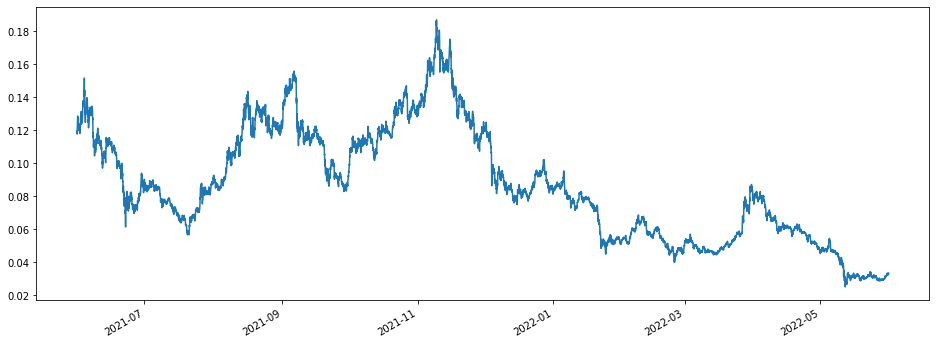

In [570]:
tickerS = "VET-USD"
interval_='1h'
period_='1y'
period_indic = '2y'
vivod = 30
diff_ch=1
dop_fich_BTC = 1
dop_fich = 1
choose = 3

tickerData = yf.Ticker(tickerS)
tickerDf = tickerData.history(period = period_, interval = interval_)
tickerDf.Close.plot(figsize=(16,6))

# Основные функции

In [571]:
def box_cox(data, columnOld, columnNew):
    trans, lambda_ = boxcox(data[columnOld].values)
    data[columnNew] = trans
    return lambda_
    
def inv_box_cox(data, lambda_):
    return inv_boxcox(data, lambda_)
    
def diff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].diff()
    
def inv_diff(base, predict):
    summ=[i+j for i,j in zip(base[len(base)-len(predict)-1:-1], predict)]
    return np.array(summ).reshape(-1,1)

def minmax(data, columnOld, columnNew):
    scaler = MinMaxScaler()
    data[columnNew] = scaler.fit_transform(data[columnOld].values.reshape(-1,1))
    return scaler.fit(data[columnOld].values.reshape(-1,1))

def inv_minmax(data, obj):
    return obj.inverse_transform(data).reshape(-1,1)
    
def lag_fich(data, columnOld):
    prediction_window = 10
    prediction_columns = [columnOld]
    for i in range(1, prediction_window+1):
        col_name = f'shift_{i}'
        prediction_columns.append(col_name)
        data[col_name] = data[prediction_columns[0]].shift(i)
    
    return data[prediction_columns].dropna(), prediction_columns

def all_transform(dataf, pupu, box_cox_ch=1):
    if box_cox_ch == 1:
        lambda_dataf = box_cox(dataf, pupu, 'boxcox')
        data1 = dataf['boxcox'].copy()
        diff(dataf, 'boxcox', 'diff')
        return lambda_dataf, data1
    else:
        lambda_dataf = 0
        data1 = dataf[pupu].copy()
        diff(dataf, pupu, 'diff')
        return lambda_dataf, data1
box_cox_ch=0   
def inv_all_transform(data1, data_test, lambda_data, box_cox_ch=1):
    if box_cox_ch == 1:
        inv_data_test_from_diff_to_boxcox = inv_diff(data1, data_test.values.reshape(-1,1))
        inv_data_test = inv_boxcox(inv_data_test_from_diff_to_boxcox, lambda_data)
        return inv_data_test
    else:
        inv_data_test = inv_diff(data1, data_test.values.reshape(-1,1))
        return inv_data_test

def add_feature(name, feature, prediction_columns, high, low):
    prediction_columns.append(name)

    high[name] = feature[len(feature)-len(high):]
    low[name] = feature[len(feature)-len(low):]
   
def metrics(predicted, real):
    from sklearn.metrics import mean_squared_error
    print('mean_squared_error (MSE)', mean_squared_error(predicted,real))

    from sklearn.metrics import mean_absolute_error
    print('mean_absolute_error (MAE)', mean_absolute_error(predicted, real))

    from sklearn.metrics import mean_absolute_percentage_error
    print('mean_absolute_percentage_error (MAPE)', mean_absolute_percentage_error(predicted, real))
    
    from sklearn.metrics import r2_score
    print('r2_score (R^2)', r2_score(predicted,real))

# Предобработка данных

In [572]:
low = tickerDf[:].copy()
high = tickerDf[:].copy()
close = tickerDf[:].copy()

high_real = high['High'].copy()
low_real = low['Low'].copy()

In [573]:
if diff_ch ==1:
    
    lambda_high, high1 = all_transform(high, 'High', box_cox_ch)
    lambda_low, low1= all_transform(low, 'Low', box_cox_ch)


In [574]:
if box_cox_ch == 1:
    high['boxcox'].plot(figsize=(16,6), linewidth = 1)

In [575]:
if diff_ch == 1:
    high, prediction_columns = lag_fich(high, 'diff')

    low, prediction_columns = lag_fich(low, 'diff')
else:
    high, prediction_columns_high = lag_fich(high, 'High')

    low, prediction_columns_low = lag_fich(low, 'Low')

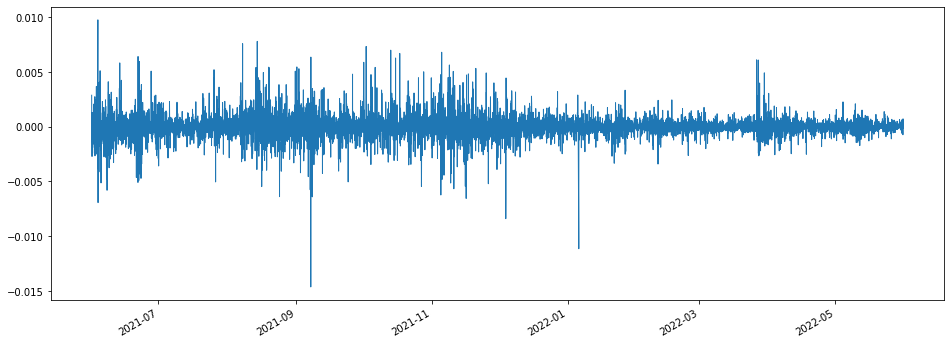

In [576]:
if diff_ch == 1:
    high['diff'].plot(figsize=(16,6), linewidth = 1)

# Фичи

In [577]:
if dop_fich_BTC == 1:
    ''''''
    tickerBTC = "BTC-USD"
    tickerDataBTC = yf.Ticker(tickerBTC)
    tickerDf_features_BTC = tickerDataBTC.history(period = period_, interval = interval_)

    featuresBTC_high = tickerDf_features_BTC[:-1].shift().copy()
    featuresBTC_low = tickerDf_features_BTC[:-1].shift().copy()

    _ , _ = all_transform(featuresBTC_high, 'High', box_cox_ch)

    _ , _ = all_transform(featuresBTC_low, 'Low', box_cox_ch)

    prediction_columns.append('BTC')

    high['BTC'] = featuresBTC_high['diff'][len(featuresBTC_high['diff'])-len(high):]
    low['BTC'] = featuresBTC_low['diff'][len(featuresBTC_low['diff'])-len(low):]

    tickerDf_features_BTC_indic = tickerDataBTC.history(period = period_, interval = interval_)
    features = tickerDf_features_BTC_indic[:-1].copy()

    output = talib.WILLR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('WILLR_BTC', output, prediction_columns, high, low)

    output = talib.PLUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('PLUS_DI_BTC', output, prediction_columns, high, low)

    output = talib.DX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('DX_BTC', output, prediction_columns, high, low)

    output = talib.CCI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('CCI_BTC', output, prediction_columns, high, low)

    output = talib.ADXR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADXR_BTC', output, prediction_columns, high, low)

    output = talib.ULTOSC(features['High'], features['Low'], features['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    add_feature('ULTOSC_BTC', output, prediction_columns, high, low)

    output = talib.ADX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADX_BTC', output, prediction_columns, high, low)

    output = talib.APO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('APO_BTC', output, prediction_columns, high, low)

    output = talib.AROONOSC(features['High'], features['Low'], timeperiod=14)
    add_feature('AROONOSC_BTC', output, prediction_columns, high, low)

    output = talib.BOP(features['Open'], features['High'], features['Low'], features['Close'])
    add_feature('BOP_BTC', output, prediction_columns, high, low)

    output = talib.CMO(features['Close'], timeperiod=14)
    add_feature('CMO_BTC', output, prediction_columns, high, low)

    output = talib.MINUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('MINUS_DI_BTC', output, prediction_columns, high, low)

    output = talib.MINUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('MINUS_DM_BTC', output, prediction_columns, high, low)

    output = talib.MOM(features['Close'], timeperiod=10)
    add_feature('MOM_BTC', output, prediction_columns, high, low)

    output = talib.PLUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('PLUS_DM_BTC', output, prediction_columns, high, low)

    output = talib.PPO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('PPO_BTC', output, prediction_columns, high, low)

    output = talib.ROC(features['Close'], timeperiod=10)
    add_feature('ROC_BTC', output, prediction_columns, high, low)

    output = talib.ROCP(features['Close'], timeperiod=10)
    add_feature('ROCP_BTC', output, prediction_columns, high, low)

    output = talib.ROCR(features['Close'], timeperiod=10)
    add_feature('ROCR_BTC', output, prediction_columns, high, low)

    output = talib.ROCR100(features['Close'], timeperiod=10)
    add_feature('ROCR100_BTC', output, prediction_columns, high, low)

    output = talib.RSI(features['Close'], timeperiod=14)
    add_feature('RSI_BTC', output, prediction_columns, high, low)

    output = talib.TRIX(features['Close'], timeperiod=30)
    add_feature('TRIX_BTC', output, prediction_columns, high, low)

    output = talib.MIDPRICE(features['High'], features['Low'], timeperiod=14)
    add_feature('MIDPRICE_BTC', output, prediction_columns, high, low)

    output = talib.DEMA(features['Close'], timeperiod=30)
    add_feature('DEMA_BTC', output, prediction_columns, high, low)

    output = talib.EMA(features['Close'], timeperiod=30)
    add_feature('EMA_BTC', output, prediction_columns, high, low)

    output = talib.HT_TRENDLINE(features['Close'])
    add_feature('HT_TRENDLINE_BTC', output, prediction_columns, high, low)

    output = talib.KAMA(features['Close'], timeperiod=30)
    add_feature('KAMA_BTC', output, prediction_columns, high, low)

    output = talib.MA(features['Close'], timeperiod=30, matype=0)
    add_feature('MA_BTC', output, prediction_columns, high, low)

    output = talib.MIDPOINT(features['Close'], timeperiod=14)
    add_feature('MIDPOINT_BTC', output, prediction_columns, high, low)

    output = talib.SMA(features['Close'], timeperiod=30)
    add_feature('SMA_BTC', output, prediction_columns, high, low)

    output = talib.TEMA(features['Close'], timeperiod=30)
    add_feature('TEMA_BTC', output, prediction_columns, high, low)

    output = talib.TRIMA(features['Close'], timeperiod=30)
    add_feature('TRIMA_BTC', output, prediction_columns, high, low)

    output = talib.WMA(features['Close'], timeperiod=30)
    add_feature('WMA_BTC', output, prediction_columns, high, low)

    output = talib.ATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ATR_BTC', output, prediction_columns, high, low)

    output = talib.NATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('NATR_BTC', output, prediction_columns, high, low)

    output = talib.TRANGE(features['High'], features['Low'], features['Close'])
    add_feature('TRANGE_BTC', output, prediction_columns, high, low)

    output = talib.HT_DCPERIOD(features['Close'])
    add_feature('HT_DCPERIOD_BTC', output, prediction_columns, high, low)

    output = talib.HT_DCPHASE(features['Close'])
    add_feature('WHT_DCPHASEMA_BTC', output, prediction_columns, high, low)

    output = talib.HT_TRENDMODE(features['Close'])
    add_feature('HT_TRENDMODE_BTC', output, prediction_columns, high, low)

    output = talib.BETA(features['High'], features['Low'], timeperiod=5)
    add_feature('BETA_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG(features['Close'], timeperiod=14)
    add_feature('LINEARREG_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG_ANGLE(features['Close'], timeperiod=14)
    add_feature('WLINEARREG_ANGLEMA_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG_INTERCEPT(features['Close'], timeperiod=14)
    add_feature('LINEARREG_INTERCEPT_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG_SLOPE(features['Close'], timeperiod=14)
    add_feature('LINEARREG_SLOPE_BTC', output, prediction_columns, high, low)

    output = talib.STDDEV(features['Close'], timeperiod=5, nbdev=1)
    add_feature('STDDEV_BTC', output, prediction_columns, high, low)

    output = talib.TSF(features['Close'], timeperiod=14)
    add_feature('TSF_BTC', output, prediction_columns, high, low)

    output = talib.VAR(features['Close'], timeperiod=5, nbdev=1)
    add_feature('VAR_BTC', output, prediction_columns, high, low)
    
    ''''''
    
    len(prediction_columns)-11
    

In [578]:

if dop_fich ==1:
    tickerDf_features = tickerData.history(period = period_, interval = interval_)
    features = tickerDf_features[:-1].copy()
    ##############
    high_fich = add_all_ta_features(features, 
                                   open = 'Open', 
                                   high = 'High', 
                                   low = 'Low', 
                                   close = 'Close', 
                                   volume = 'Volume', 
                                   fillna = True)

    low_fich = add_all_ta_features(features, 
                                   open = 'Open', 
                                   high = 'High', 
                                   low = 'Low', 
                                   close = 'Close', 
                                   volume = 'Volume', 
                                   fillna = True)

    for i in high_fich.columns.tolist()[7:]:
        high[i] = high_fich[i]
        low[i] = low_fich[i]
        prediction_columns.append(i)

    ############

    #60

    #Momentum Indicator Functions - 22

    output = talib.WILLR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('WILLR', output, prediction_columns, high, low)

    output = talib.PLUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('PLUS_DI', output, prediction_columns, high, low)

    output = talib.DX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('DX', output, prediction_columns, high, low)

    output = talib.CCI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('CCI', output, prediction_columns, high, low)

    output = talib.ADXR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADXR', output, prediction_columns, high, low)

    output = talib.ULTOSC(features['High'], features['Low'], features['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    add_feature('ULTOSC', output, prediction_columns, high, low)

    output = talib.ADX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADX', output, prediction_columns, high, low)

    output = talib.APO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('APO', output, prediction_columns, high, low)

    output = talib.AROONOSC(features['High'], features['Low'], timeperiod=14)
    add_feature('AROONOSC', output, prediction_columns, high, low)

    output = talib.BOP(features['Open'], features['High'], features['Low'], features['Close'])
    add_feature('BOP', output, prediction_columns, high, low)

    output = talib.CMO(features['Close'], timeperiod=14)
    add_feature('CMO', output, prediction_columns, high, low)

    output = talib.MINUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('MINUS_DI', output, prediction_columns, high, low)

    output = talib.MINUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('MINUS_DM', output, prediction_columns, high, low)

    output = talib.MOM(features['Close'], timeperiod=10)
    add_feature('MOM', output, prediction_columns, high, low)

    output = talib.PLUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('PLUS_DM', output, prediction_columns, high, low)

    output = talib.PPO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('PPO', output, prediction_columns, high, low)

    output = talib.ROC(features['Close'], timeperiod=10)
    add_feature('ROC', output, prediction_columns, high, low)

    output = talib.ROCP(features['Close'], timeperiod=10)
    add_feature('ROCP', output, prediction_columns, high, low)

    output = talib.ROCR(features['Close'], timeperiod=10)
    add_feature('ROCR', output, prediction_columns, high, low)

    output = talib.ROCR100(features['Close'], timeperiod=10)
    add_feature('ROCR100', output, prediction_columns, high, low)

    output = talib.RSI(features['Close'], timeperiod=14)
    add_feature('RSI', output, prediction_columns, high, low)

    output = talib.TRIX(features['Close'], timeperiod=30)
    add_feature('TRIX', output, prediction_columns, high, low)


    #Overlap Studies Functions - 11

    output = talib.MIDPRICE(features['High'], features['Low'], timeperiod=14)
    add_feature('MIDPRICE', output, prediction_columns, high, low)

    output = talib.DEMA(features['Close'], timeperiod=30)
    add_feature('DEMA', output, prediction_columns, high, low)

    output = talib.EMA(features['Close'], timeperiod=30)
    add_feature('EMA', output, prediction_columns, high, low)

    output = talib.HT_TRENDLINE(features['Close'])
    add_feature('HT_TRENDLINE', output, prediction_columns, high, low)

    output = talib.KAMA(features['Close'], timeperiod=30)
    add_feature('KAMA', output, prediction_columns, high, low)

    output = talib.MA(features['Close'], timeperiod=30, matype=0)
    add_feature('MA', output, prediction_columns, high, low)

    output = talib.MIDPOINT(features['Close'], timeperiod=14)
    add_feature('MIDPOINT', output, prediction_columns, high, low)

    output = talib.SMA(features['Close'], timeperiod=30)
    add_feature('SMA', output, prediction_columns, high, low)

    output = talib.TEMA(features['Close'], timeperiod=30)
    add_feature('TEMA', output, prediction_columns, high, low)

    output = talib.TRIMA(features['Close'], timeperiod=30)
    add_feature('TRIMA', output, prediction_columns, high, low)

    output = talib.WMA(features['Close'], timeperiod=30)
    add_feature('WMA', output, prediction_columns, high, low)


    #Volatility Indicator Functions - 3

    output = talib.ATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ATR', output, prediction_columns, high, low)

    output = talib.NATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('NATR', output, prediction_columns, high, low)

    output = talib.TRANGE(features['High'], features['Low'], features['Close'])
    add_feature('TRANGE', output, prediction_columns, high, low)



    #Cycle Indicator Functions - 3

    output = talib.HT_DCPERIOD(features['Close'])
    add_feature('HT_DCPERIOD', output, prediction_columns, high, low)

    output = talib.HT_DCPHASE(features['Close'])
    add_feature('WHT_DCPHASEMA', output, prediction_columns, high, low)

    output = talib.HT_TRENDMODE(features['Close'])
    add_feature('HT_TRENDMODE', output, prediction_columns, high, low)



    #Statistic Functions - 8

    output = talib.BETA(features['High'], features['Low'], timeperiod=5)
    add_feature('BETA', output, prediction_columns, high, low)

    output = talib.LINEARREG(features['Close'], timeperiod=14)
    add_feature('LINEARREG', output, prediction_columns, high, low)

    output = talib.LINEARREG_ANGLE(features['Close'], timeperiod=14)
    add_feature('WLINEARREG_ANGLEMA', output, prediction_columns, high, low)

    output = talib.LINEARREG_INTERCEPT(features['Close'], timeperiod=14)
    add_feature('LINEARREG_INTERCEPT', output, prediction_columns, high, low)

    output = talib.LINEARREG_SLOPE(features['Close'], timeperiod=14)
    add_feature('LINEARREG_SLOPE', output, prediction_columns, high, low)

    output = talib.STDDEV(features['Close'], timeperiod=5, nbdev=1)
    add_feature('STDDEV', output, prediction_columns, high, low)

    output = talib.TSF(features['Close'], timeperiod=14)
    add_feature('TSF', output, prediction_columns, high, low)

    output = talib.VAR(features['Close'], timeperiod=5, nbdev=1)
    add_feature('VAR', output, prediction_columns, high, low)



    #Math Transform Functions - 13

    output = talib.ACOS(features['Close'])
    add_feature('ACOS', output, prediction_columns, high, low)

    output = talib.ASIN(features['Close'])
    add_feature('ASIN', output, prediction_columns, high, low)

    output = talib.ATAN(features['Close'])
    add_feature('ATAN', output, prediction_columns, high, low)

    output = talib.COS(features['Close'])
    add_feature('COS', output, prediction_columns, high, low)

    output = talib.COSH(features['Close'])
    add_feature('COSH', output, prediction_columns, high, low)

    output = talib.EXP(features['Close'])
    add_feature('EXP', output, prediction_columns, high, low)

    output = talib.LN(features['Close'])
    add_feature('LN', output, prediction_columns, high, low)

    output = talib.LOG10(features['Close'])
    add_feature('LOG10', output, prediction_columns, high, low)

    output = talib.SIN(features['Close'])
    add_feature('SIN', output, prediction_columns, high, low)

    output = talib.SINH(features['Close'])
    add_feature('SINH', output, prediction_columns, high, low)

    output = talib.SQRT(features['Close'])
    add_feature('SQRT', output, prediction_columns, high, low)

    output = talib.TAN(features['Close'])
    add_feature('TAN', output, prediction_columns, high, low)

    output = talib.TANH(features['Close'])
    add_feature('TANH', output, prediction_columns, high, low)
    ''''''

    len(prediction_columns)-11

/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.co

# Обучение - High

In [579]:
if diff_ch == 1:
    X = high[prediction_columns[1:]]
    y = high[prediction_columns[0]]
else:
    X = high[prediction_columns_high[1:]]
    y = high[prediction_columns_high[0]]

high_x_train, high_x_test, high_train, high_test = train_test_split(X, y, test_size=0.33, random_state = 42, shuffle = False)

high_x_train.fillna(value = 0, inplace=True)
high_x_test.fillna(value = 0, inplace=True)
high_train.fillna(value = 0, inplace=True)
high_test.fillna(value = 0, inplace=True)

if choose == 1:
    regressor_high = LinearRegression()
    regressor_high.fit(high_x_train, high_train)
    
elif choose == 2:
    ######### RandomForest
    max_depth_les = 100
    min_samples_leaf_les = 10
    #########
    regressor_high = RandomForestRegressor(max_depth=max_depth_les, random_state=0, min_samples_leaf=min_samples_leaf_les)
    regressor_high.fit(high_x_train, high_train)
    
elif choose == 3:
    ######### CatBoost
    iterations_cat=500    #500
    learning_rate_cat=0.03 #0.03
    depth_cat=8         #8
    l2_leaf_reg_cat=7
    #########
    regressor_high = CatBoostRegressor(iterations=iterations_cat,
                                       learning_rate=learning_rate_cat,
                                       depth=depth_cat,
                                       l2_leaf_reg=l2_leaf_reg_cat)
    regressor_high.fit(high_x_train, high_train)

0:	learn: 0.0012218	total: 155ms	remaining: 1m 17s
1:	learn: 0.0012057	total: 273ms	remaining: 1m 7s
2:	learn: 0.0011904	total: 396ms	remaining: 1m 5s
3:	learn: 0.0011777	total: 517ms	remaining: 1m 4s
4:	learn: 0.0011653	total: 652ms	remaining: 1m 4s
5:	learn: 0.0011519	total: 771ms	remaining: 1m 3s
6:	learn: 0.0011387	total: 894ms	remaining: 1m 2s
7:	learn: 0.0011272	total: 1.02s	remaining: 1m 2s
8:	learn: 0.0011160	total: 1.14s	remaining: 1m 2s
9:	learn: 0.0011032	total: 1.26s	remaining: 1m 1s
10:	learn: 0.0010925	total: 1.38s	remaining: 1m 1s
11:	learn: 0.0010789	total: 1.5s	remaining: 1m 1s
12:	learn: 0.0010693	total: 1.63s	remaining: 1m 1s
13:	learn: 0.0010575	total: 1.76s	remaining: 1m
14:	learn: 0.0010475	total: 1.88s	remaining: 1m
15:	learn: 0.0010365	total: 2.01s	remaining: 1m
16:	learn: 0.0010260	total: 2.13s	remaining: 1m
17:	learn: 0.0010172	total: 2.26s	remaining: 1m
18:	learn: 0.0010081	total: 2.39s	remaining: 1m
19:	learn: 0.0009987	total: 2.52s	remaining: 1m
20:	learn: 

# Feature importance - High

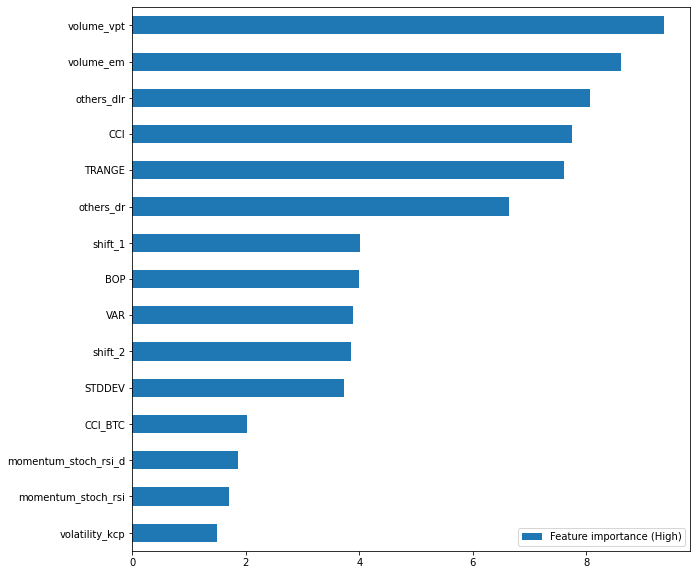

In [580]:
if choose == 3:
    if diff_ch == 1:
        df_features_high = pd.DataFrame(regressor_high.get_feature_importance(), 
                                   index = prediction_columns[1:], 
                                   columns = ['Feature importance (High)'])

        df_features_high = df_features_high.sort_values(by=['Feature importance (High)'])
        df_features_high[-15:].plot(kind='barh', figsize=(10,10))
    else:
        df_features_high = pd.DataFrame(regressor_high.get_feature_importance(), 
                                   index = prediction_columns_high[1:], 
                                   columns = ['Feature importance (High)'])

        df_features_high = df_features_high.sort_values(by=['Feature importance (High)'])
        df_features_high[-15:].plot(kind='barh', figsize=(10,10))


# Обратные преобразования - High

In [581]:
if diff_ch == 1:
    inv_high_test = inv_all_transform(high1, high_test, lambda_high, box_cox_ch)
    inv_high_x = inv_all_transform(high1, pd.Series(regressor_high.predict(high_x_test)), lambda_high, box_cox_ch)


# Обучение - Low

In [582]:
if diff_ch == 1:
    X_low = low[prediction_columns[1:]]
    y_low = low[prediction_columns[0]]
else:
    X_low = low[prediction_columns_low[1:]]
    y_low = low[prediction_columns_low[0]]
    
low_x_train, low_x_test, low_train, low_test = train_test_split(X_low, y_low, test_size=0.33, random_state = 42, shuffle = False)

low_x_train.fillna(value = 0, inplace=True)
low_x_test.fillna(value = 0, inplace=True)
low_train.fillna(value = 0, inplace=True)
low_test.fillna(value = 0, inplace=True)

if choose == 1:
    from sklearn.linear_model import LinearRegression
    regressor_low = LinearRegression()
    regressor_low.fit(low_x_train, low_train)
    
elif choose == 2:
    from sklearn.ensemble import RandomForestRegressor
    regressor_low = RandomForestRegressor(max_depth=max_depth_les, random_state=0, min_samples_leaf=min_samples_leaf_les)
    regressor_low.fit(low_x_train, low_train)
    
elif choose == 3:
    from catboost import CatBoostRegressor
    regressor_low = CatBoostRegressor(iterations=iterations_cat,
                                       learning_rate=learning_rate_cat,
                                       depth=depth_cat,
                                       l2_leaf_reg=l2_leaf_reg_cat)
    regressor_low.fit(low_x_train, low_train)

0:	learn: 0.0016830	total: 143ms	remaining: 1m 11s
1:	learn: 0.0016649	total: 263ms	remaining: 1m 5s
2:	learn: 0.0016498	total: 385ms	remaining: 1m 3s
3:	learn: 0.0016364	total: 507ms	remaining: 1m 2s
4:	learn: 0.0016212	total: 635ms	remaining: 1m 2s
5:	learn: 0.0016048	total: 758ms	remaining: 1m 2s
6:	learn: 0.0015885	total: 881ms	remaining: 1m 2s
7:	learn: 0.0015744	total: 1000ms	remaining: 1m 1s
8:	learn: 0.0015613	total: 1.13s	remaining: 1m 1s
9:	learn: 0.0015489	total: 1.25s	remaining: 1m 1s
10:	learn: 0.0015362	total: 1.37s	remaining: 1m
11:	learn: 0.0015249	total: 1.48s	remaining: 1m
12:	learn: 0.0015132	total: 1.61s	remaining: 1m
13:	learn: 0.0014997	total: 1.73s	remaining: 1m
14:	learn: 0.0014895	total: 1.86s	remaining: 1m
15:	learn: 0.0014782	total: 1.98s	remaining: 59.9s
16:	learn: 0.0014667	total: 2.1s	remaining: 59.6s
17:	learn: 0.0014571	total: 2.22s	remaining: 59.5s
18:	learn: 0.0014484	total: 2.34s	remaining: 59.3s
19:	learn: 0.0014372	total: 2.46s	remaining: 59.1s
20:	

# Feature importance - Low

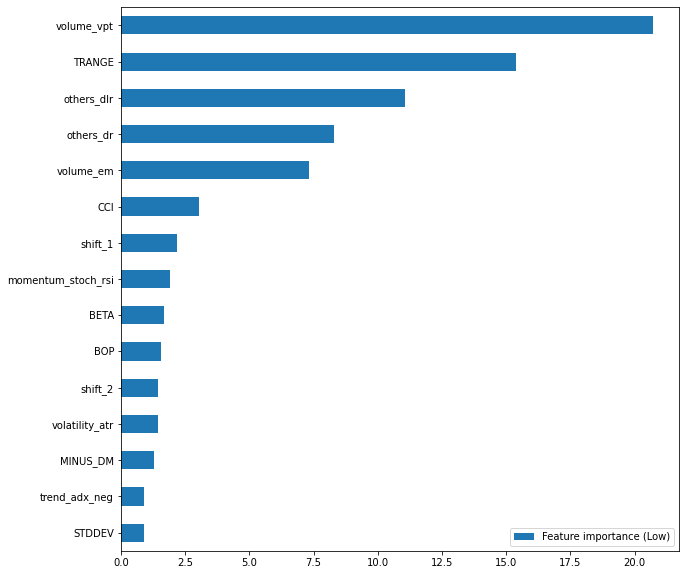

In [583]:
if choose == 3:
    if diff_ch == 1:
        df_features_low = pd.DataFrame(regressor_low.get_feature_importance(), 
                                   index = prediction_columns[1:], 
                                   columns = ['Feature importance (Low)'])

        df_features_low = df_features_low.sort_values(by=['Feature importance (Low)'])
        df_features_low[-15:].plot(kind='barh', figsize=(10,10))
    else:
        df_features_low = pd.DataFrame(regressor_low.get_feature_importance(), 
                                   index = prediction_columns_low[1:], 
                                   columns = ['Feature importance (Low)'])

        df_features_low = df_features_low.sort_values(by=['Feature importance (Low)'])
        df_features_low[-15:].plot(kind='barh', figsize=(10,10))

# Обратные преобразования - Low

In [584]:
if diff_ch == 1:
    inv_low_test = inv_all_transform(low1, low_test, lambda_low, box_cox_ch)
    inv_low_x = inv_all_transform(low1, pd.Series(regressor_low.predict(low_x_test)), lambda_low, box_cox_ch)

# Графики - High

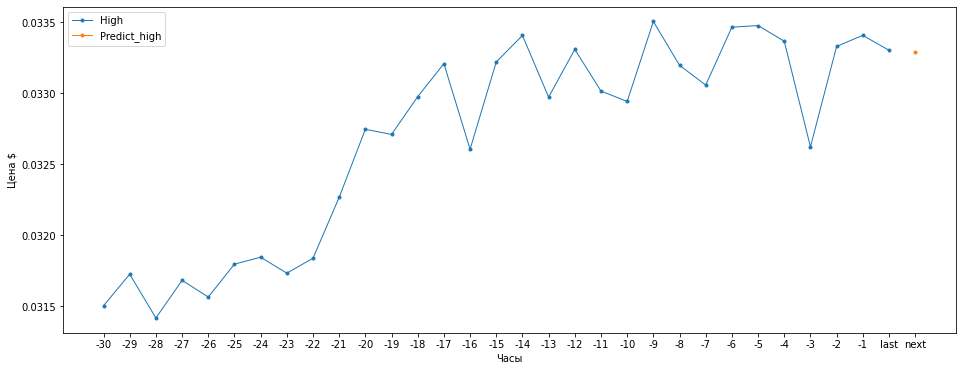

In [585]:
if diff_ch == 1:
    df=pd.DataFrame(inv_high_test[-vivod-2:-1])
    df.rename(columns = {0:'High'},inplace =True)

    df1_high=pd.DataFrame()
    df1_high['High'] = pd.concat([df['High'], pd.Series(np.NaN)],ignore_index=True)
    df1_high['Predict_high'] = np.NaN
    df1_high['Predict_high'].iloc[-1] = inv_high_x[-1]

    df1_high.index = [i for i in range(-vivod,2,1)]
    ax = df1_high[-vivod-2:].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы', xticks = range(-vivod,2,1))
    ax.set_xticklabels(list(range(-vivod,0,1))+['last', 'next'])
else:
    df=pd.DataFrame(high_test.values[-vivod-2:-1])
    df.rename(columns = {0:'High'},inplace =True)

    df1_high=pd.DataFrame()
    df1_high['High'] = pd.concat([df['High'], pd.Series(np.NaN)],ignore_index=True)
    df1_high['Predict_high'] = np.NaN
    df1_high['Predict_high'].iloc[-1] = regressor_high.predict(high_x_test)[-1] 

    df1_high.index = [i for i in range(-vivod,2,1)]
    ax = df1_high[-vivod-2:].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы', xticks = range(-vivod,2,1))
    ax.set_xticklabels(list(range(-vivod,0,1))+['last', 'next'])

# Графики - Low

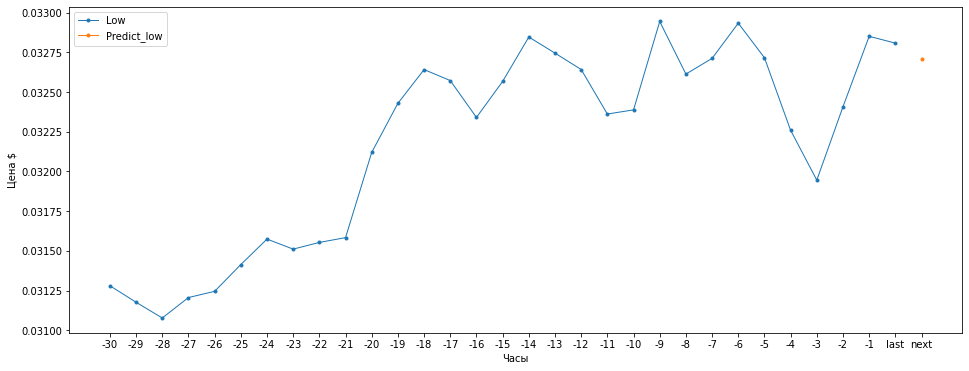

In [586]:
if diff_ch == 1:
    df=pd.DataFrame(inv_low_test[-vivod-2:-1])
    df.rename(columns = {0:'Low'},inplace =True)

    df1_low=pd.DataFrame()
    df1_low['Low'] = pd.concat([df['Low'], pd.Series(np.NaN)],ignore_index=True)
    df1_low['Predict_low'] = np.NaN
    df1_low['Predict_low'].iloc[-1] = inv_low_x[-1]

    df1_low.index = [i for i in range(-vivod,2,1)]
    ax = df1_low[-vivod-2:].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы', xticks = range(-vivod,2,1))
    ax.set_xticklabels(list(range(-vivod,0,1))+['last', 'next'])
else:
    df=pd.DataFrame(low_test.values[-vivod-2:-1])
    df.rename(columns = {0:'Low'},inplace =True)

    df1_low=pd.DataFrame()
    df1_low['Low'] = pd.concat([df['Low'], pd.Series(np.NaN)],ignore_index=True)
    df1_low['Predict_low'] = np.NaN
    df1_low['Predict_low'].iloc[-1] = regressor_low.predict(low_x_test)[-1] 

    df1_low.index = [i for i in range(-vivod,2,1)]
    ax = df1_low[-vivod-2:].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы', xticks = range(-vivod,2,1))
    ax.set_xticklabels(list(range(-vivod,0,1))+['last', 'next'])

# Вывод

High: 0.03330349177122116  ->  0.03329305678392208 
Low:  0.032809071242809296  ->  0.032706089135787125


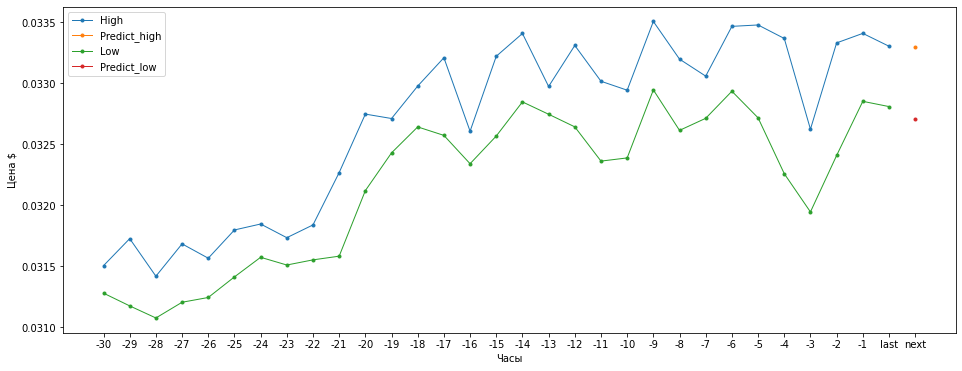

In [587]:
df_for = pd.DataFrame([df1_high['High'], df1_high['Predict_high'], df1_low['Low'], df1_low['Predict_low']]).T
ax = df_for[-vivod-2:].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы', xticks = range(-vivod,2,1))
ax.set_xticklabels(list(range(-vivod,0,1))+['last', 'next'])
print('High:', df1_high['High'].iloc[-2],' -> ', df1_high['Predict_high'].iloc[-1], '\nLow: ', df1_low['Low'].iloc[-2], ' -> ', df1_low['Predict_low'].iloc[-1])